In [1]:
# librerie utili
import os
import torch
import numpy as np
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import random
import collections
from tqdm import tqdm
import joblib 
from data_augmentation import build_balanced_augmented_tensor_dataset

In [2]:
# riproducibilità
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
# configurazione
image_size = 224 # dimensione a cui ridimensionare ogni immagine
batch_size = 32  # batch size per i DataLoader
n_components = 2342 # componenti principali che spiegano l 95% della soglia
noise_std = 0.05
# valori diversi di noise_std provati [0.0, 0.01, 0.05, 0.1, 0.2, 0.3]
train_ratio, val_ratio = 0.7, 0.15  # percentuali per suddividere in train/val/test

pretty_labels = ['adenocarcinoma', 'beigno', 'carcinoma squamoso']  # nome delle classi più leggibili

In [ ]:
# percorsi utili
base_dir = os.getcwd()  # percorso base
data_dir = os.path.join(base_dir, 'data_histo') # percorso dataset
# percorso per salvare output
output_folder = os.path.join(base_dir, "pca_outputs")
os.makedirs(output_folder, exist_ok=True) # crea se non esiste
save_path = os.path.join(output_folder, f'pca_data_{n_components}_{noise_std}.pth')
pca_model_path = os.path.join(output_folder, f'pca_model_{n_components}_{noise_std}.pkl') 

In [ ]:
# trasformazioni base (usate per val/test)
transform_base = transforms.Compose([
    transforms.Resize((image_size, image_size)), # ridimensiona le immagini
    transforms.ToTensor() # converte in tensore
])

In [ ]:
# caricamento e split
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform_base)  # carica tutte le immagini con le etichette
total_size = len(full_dataset)                                           # numero totale di immagini
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size                           # il resto va al test set

# suddivisione casuale ma riproducibile
train_indices, val_indices, test_indices = random_split(
    list(range(total_size)), [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

In [7]:
train_subset = Subset(full_dataset, train_indices)
val_subset = Subset(full_dataset, val_indices)
test_subset = Subset(full_dataset, test_indices)

val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

In [ ]:
# caricamento dati augmentati (vedi file augmented_data.ipynb)
aug_data = torch.load(os.path.join("shared_augmented_data", f"augmented_train_data_{noise_std}.pt"))
train_imgs = aug_data['images']
train_labels = aug_data['labels']

# flatten immagini in vettori 1D
train_data = train_imgs.view(train_imgs.size(0), -1).numpy()

Applico data augmentation al training set...


In [9]:
# estrazione e flattening di val e test
def extract_data(loader):
    data, labels = [], []
    for images, targets in tqdm(loader, desc="Estrazione dati"):
        flat = images.view(images.size(0), -1)
        data.append(flat)
        labels.append(targets)
    data = torch.cat(data, dim=0).numpy()
    labels = torch.cat(labels).numpy()
    return data, labels

val_data, val_labels = extract_data(val_loader)
test_data, test_labels = extract_data(test_loader)

Estrazione dati: 100%|██████████| 71/71 [00:24<00:00,  2.93it/s]


In [ ]:
# normalizzazione (Z-SCORE)
# la normalizzazione viene effettuata utilizzando la media e la deviazione standard 
# calcolate solo sul set di training. Questo è fondamentale per evitare data leakage: 
# usare informazioni statistiche dai dati di validazione o test potrebbe introdurre bias
# e compromettere la validità della valutazione del modello.
mean = train_data.mean(axis=0)
std = train_data.std(axis=0) + 1e-8  # evita divisione per zero

def zscore(data):
    return (data - mean) / std

train_data = zscore(train_data)
val_data = zscore(val_data)
test_data = zscore(test_data)

In [ ]:
# PCA
pca = PCA(n_components=n_components)
train_pca = pca.fit_transform(train_data) # fit su train
val_pca = pca.transform(val_data)          # transform su val
test_pca = pca.transform(test_data)        # transform su test

Dati PCA salvati in: c:\Users\giken\Documents\Noemi\DAML-project\pca_outputs\pca_data_2342_0.05.pth
Modello PCA salvato in: c:\Users\giken\Documents\Noemi\DAML-project\pca_outputs\pca_model_2342_0.05.pkl


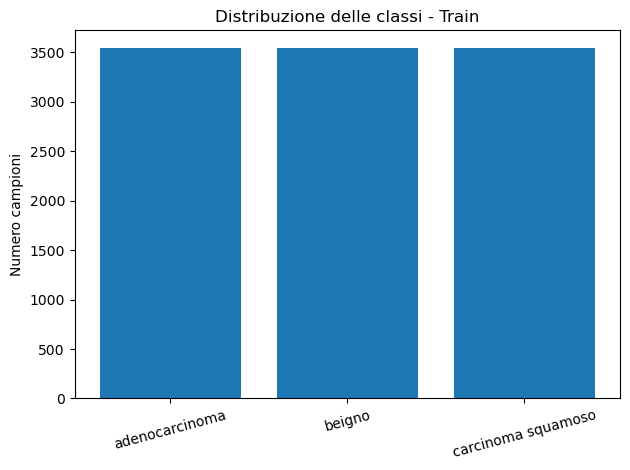

Numero totale campioni train: 10638


In [ ]:
# salvataggio
torch.save({
    'train_data': train_pca,
    'val_data': val_pca,
    'test_data': test_pca,
    'train_labels': train_labels,
    'val_labels': val_labels,
    'test_labels': test_labels,
    'class_names': pretty_labels
}, save_path)

# salvataggio PCA model (per ricostruzione immagini eventualmente)
joblib.dump(pca, pca_model_path)  # <--- NEW
print(f"Dati PCA salvati in: {save_path}")
print(f"Modello PCA salvato in: {pca_model_path}")